1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍
2. 이상치 처리 
    - lof, iso 유지
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [60]:
import pandas as pd
DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'
original_df = pd.read_csv(DATA_PATH, encoding='cp949', index_col=0, low_memory=False)
original_df.head()

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,119,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,100,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,99,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B


In [1]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.015,

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=True,
    downsampled_pass_rate=1.0,
    upsampled_total_fail_rate=0.40
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[process Log] Loading Raw Data...
[process Log] Done

[process Log] Processing Nan Value...
[process Log] Done

[process Log] Encoding Categorical Features...
[process Log] Done

[process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (92014, 23)
[Outlier-Remover Log] Without Outliers Shape : (90633, 23)
[process Log] Done

[process Log] T-Testing...
[process Log] Done

[process Log] Data Scaling (MinMaxScaler)...
[process Log] Done

[process Log] Train Test Spliting...
[process Log] Done

[process Log] Data Resampling...
[process Log] Done

======================= [Done] =======================


In [41]:
from kamp.preprocess import load_data, NanProcessor, CatFeatureEncoder
from kamp.preprocess import NAN_GRID, ENCODE_GRID

In [43]:
data_configs = load_data(DATA_PATH)

data = data_configs['data']

data = NanProcessor(nan_grid=NAN_GRID).process(data)

In [44]:
data = CatFeatureEncoder(encode_grid=ENCODE_GRID).process(data)

In [45]:
data['heating_furnace'].unique()

array([2., 1., 0.])

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(data)

data['heating_furnace'].unique()

array([2., 1., 0.])

In [39]:
import pandas as pd
df_train = pd.DataFrame()
df_train = pd.DataFrame(x_train)
df_train['passorfail'] = pd.DataFrame(y_train)
df_test = pd.DataFrame()
df_test = pd.DataFrame(x_test)
df_test['passorfail'] = pd.DataFrame(y_test)

def unique_col(column_name):
    print('*'*30 + column_name + '*'*30)
    print(f'test {column_name}:\n{df_test[column_name].unique()}\n \n train{column_name}:\n{df_train[column_name].unique()}')
    print()

for cols in df_train.columns:
    unique_col(cols)

,count,working,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,upper_mold_temp1,upper_mold_temp2,lower_mold_temp1,lower_mold_temp2,sleeve_temperature,Coolant_temperature,EMS_operation_time,tryshot_signal,mold_code,heating_furnace,passorfail
0,0.513514,1.0,0.128866,0.249485,0.785714,0.288660,0.918182,0.124650,0.036420,0.483776,0.571130,0.243319,0.009777,0.92,0.0,1.000000,1.0,0.0
1,0.357357,1.0,0.123711,0.249485,0.714286,0.260309,0.918182,0.152661,0.035230,0.681416,0.290795,0.386076,0.011173,0.92,0.0,0.833333,1.0,0.0
2,0.771772,1.0,0.131443,0.249485,0.750000,0.432990,0.895455,0.070028,0.035706,0.513274,0.349372,0.239100,0.009777,0.92,0.0,0.833333,1.0,0.0
3,0.240240,1.0,0.131443,0.249485,0.785714,0.288660,0.918182,0.101541,0.019995,0.657817,0.307531,0.309423,0.012570,0.92,0.0,0.833333,1.0,0.0
4,0.048048,1.0,0.152062,0.265979,0.750000,0.275773,0.895455,0.118347,0.032611,0.519174,0.468619,0.296062,0.009078,0.92,0.0,0.833333,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18122,0.189189,1.0,0.123711,0.247423,0.785714,0.288660,0.913636,0.126050,0.036896,0.707965,0.334728,0.291139,0.010475,0.92,0.0,1.000000,1.0,0.0
18123,0.825826,1.0,0.134021,0.251546,0.714286,0.262887,0.886364,0.052521,0.031421,0.519174,0.359833,0.384669,0.011872,0.92,0.0,0.000000,0.5,0.0
18124,0.366366,1.0,0.136598,0.253608,0.714286,0.260309,0.931818,0.143557,0.044275,0.616519,0.372385,0.172293,0.010475,0.00,0.0,1.000000,0.0,0.0
18125,0.762763,1.0,0.131443,0.251546,0.750000,0.273196,0.895455,0.126050,0.034278,0.525074,0.458159,0.304501,0.010475,0.92,0.0,0.833333,1.0,0.0


In [62]:
def unique_col(column_name):
    print('*'*30 + column_name + '*'*30)
    print(f'test {column_name}:\n{df_test[column_name].unique()}\n \n train{column_name}:\n{df_train[column_name].unique()}')
    print()

for cols in df_train.columns:
    unique_col(cols)

******************************count******************************
test count:
[0.51351351 0.35735736 0.77177177 0.24024024 0.04804805 0.56156156
 0.91591592 0.50750751 0.38138138 0.52252252 0.66066066 0.78978979
 0.18918919 0.78678679 0.36636637 0.21921922 0.5015015  0.21321321
 0.51051051 0.36336336 0.11711712 0.54954955 0.68468468 0.42642643
 0.38738739 0.31231231 0.65165165 0.8048048  0.39339339 0.72072072
 0.07207207 0.51651652 0.81081081 0.57057057 0.01801802 0.47747748
 0.11111111 0.33333333 0.16516517 0.6036036  0.69369369 0.42342342
 0.05105105 0.5975976  0.61861862 0.46546547 0.64564565 0.27027027
 0.03603604 0.56756757 0.68768769 0.81381381 0.83183183 0.23123123
 0.03303303 0.54354354 0.27627628 0.14714715 0.1981982  0.83783784
 0.6966967  0.12612613 0.59159159 0.26426426 0.17717718 0.09009009
 0.45345345 0.86186186 0.7987988  0.04204204 0.12312312 0.17117117
 0.08408408 0.60960961 0.87987988 0.20720721 0.44744745 0.12912913
 0.41441441 0.0990991  0.63663664 0.2042042  0.3783

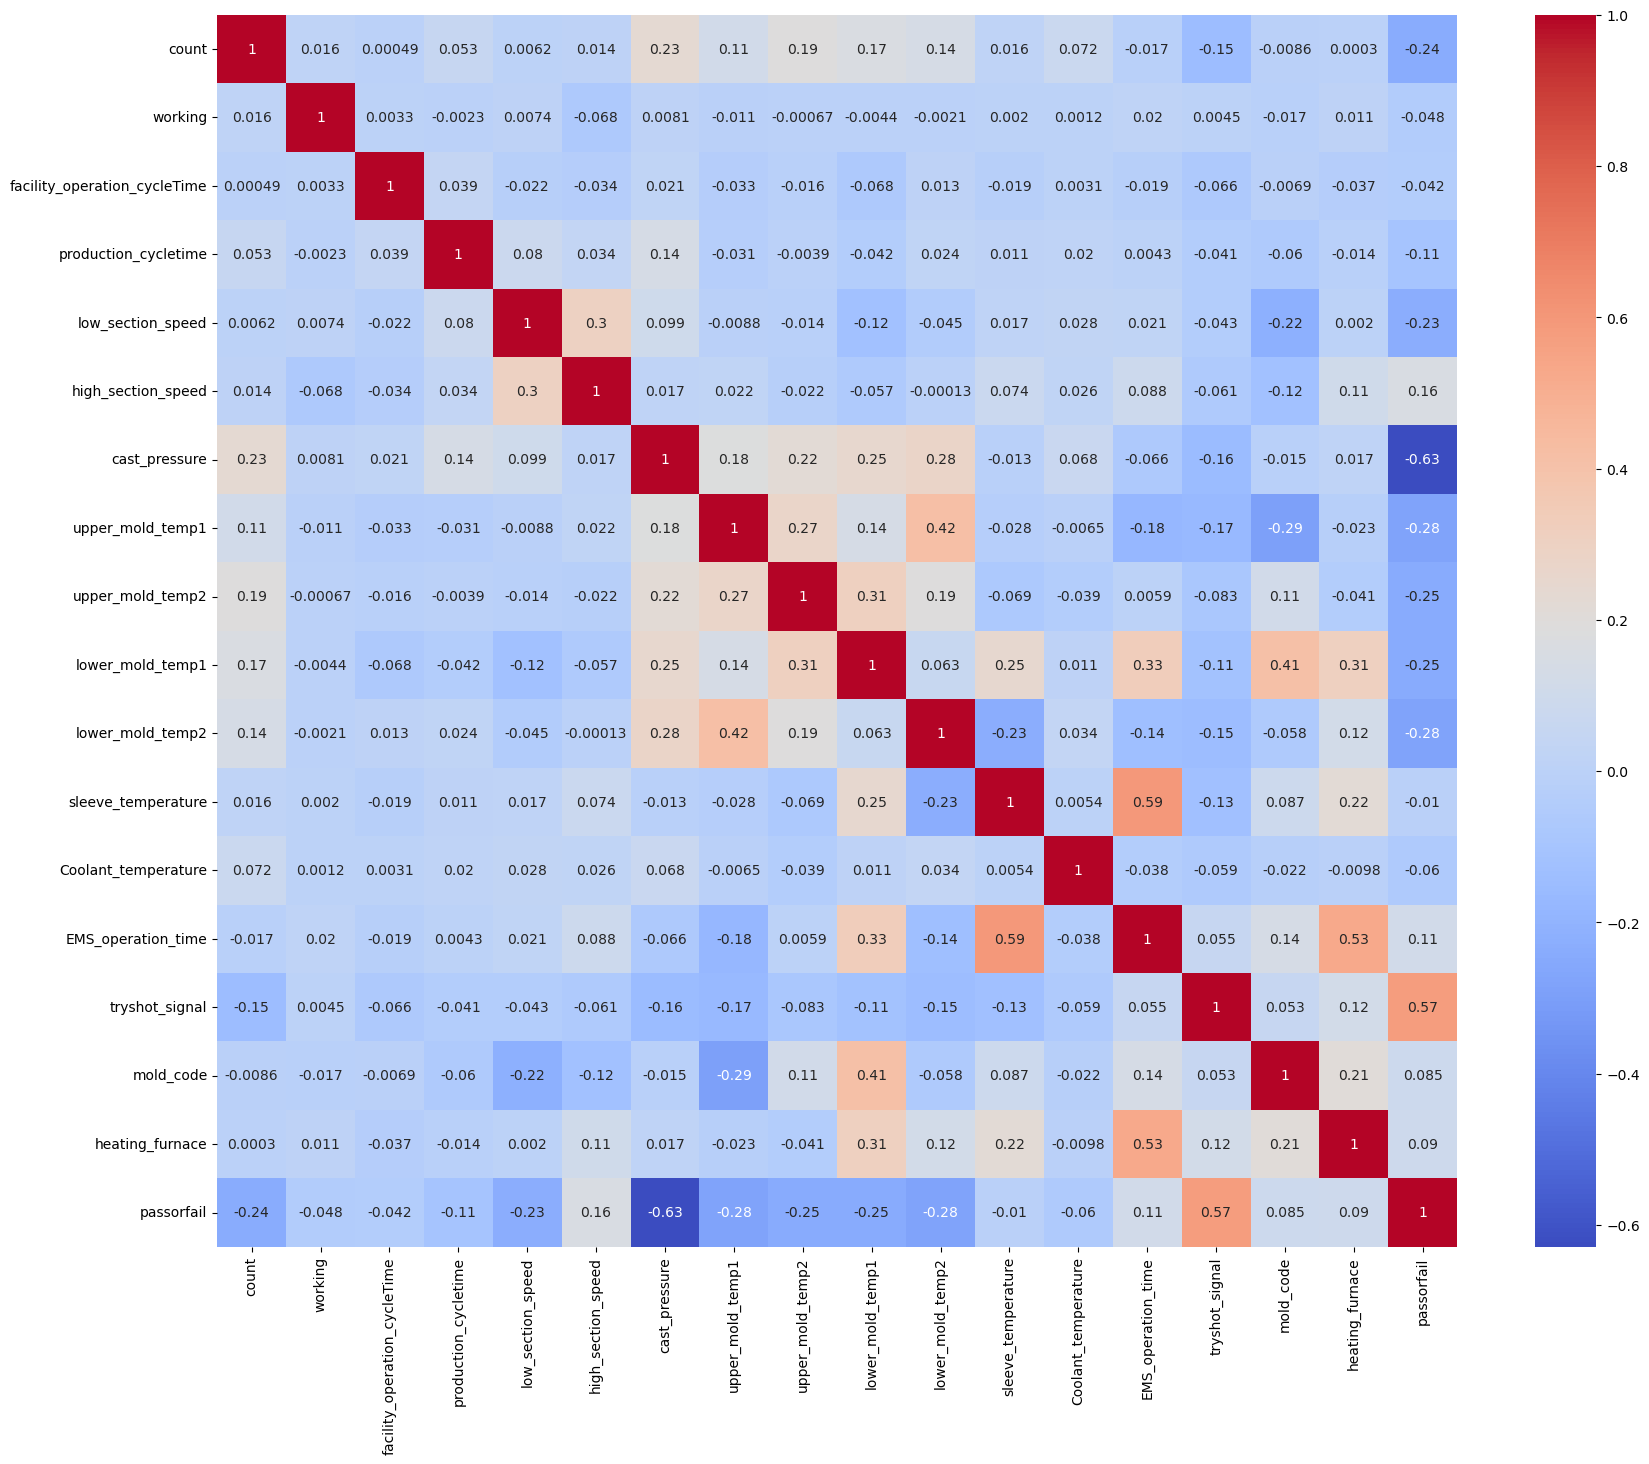

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,16))
sns.heatmap(df_train.corr(),annot=True,cmap="coolwarm")
plt.show()

# Modeling

In [129]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [130]:
model = LGBMClassifier(random_state=42)

fold_f1_score = []
n_iter = 0
idx_list = []

for train_idx, val_idx in strat_folder.split(x_train, y_train):
    train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
    train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(train_data, train_label)

    val_pred = model.predict(val_data)
    val_f1_score = f1_score(val_label, val_pred)
    val_report = classification_report(val_label, val_pred)

    n_iter += 1
    fold_f1_score.append([n_iter, val_f1_score])
    idx_list.append([train_idx, val_idx])

    print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

fold_f1_score.sort(key=lambda x : x[1], reverse=True)
print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

[LightGBM] [Info] Number of positive: 5068, number of negative: 33788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 38856, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130430 -> initscore=-1.897159
[LightGBM] [Info] Start training from score -1.897159
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8448
         1.0       0.98      0.97      0.97      1267

    accuracy                           0.99      9715
   macro avg       0.99      0.98      0.98      9715
weighted avg       0.99      0.99      0.99      9715

[LightGBM] [Info] Number of positive: 5068, number of negative: 33788
[Li

In [131]:
best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

[LightGBM] [Info] Number of positive: 5068, number of negative: 33788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3099
[LightGBM] [Info] Number of data points in the train set: 38856, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130430 -> initscore=-1.897159
[LightGBM] [Info] Start training from score -1.897159


LGBMClassifier(random_state=42)

# Validation

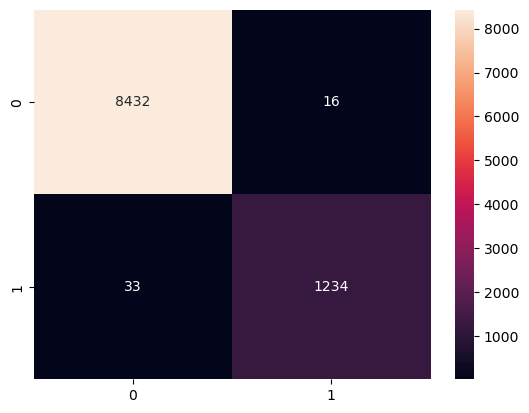

In [132]:
pred = model.predict(x_train.iloc[best_fold_val_idx])

cm = confusion_matrix(y_train[best_fold_val_idx], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

# Testing

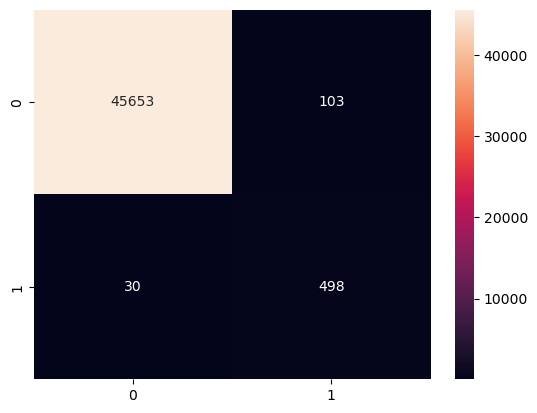

In [133]:
pred = model.predict(x_test)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [134]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45756
         1.0       0.83      0.94      0.88       528

    accuracy                           1.00     46284
   macro avg       0.91      0.97      0.94     46284
weighted avg       1.00      1.00      1.00     46284



In [135]:
print(f1_score(y_test, pred))

0.8821966341895483
